<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/hw4/hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement and train various diffusion models.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the images outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [ ]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git
!pip install ./deepul
!pip install scikit-learn

In [77]:
from deepul.hw4_helper import *

import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

import torch
torch.random.seed()

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam as Adam
from torch.utils.data import DataLoader as DataLoader
from tqdm import trange, tqdm_notebook, tqdm
from collections import OrderedDict

cuda


# Question 1: Toy Dataset [30pt]

In this question, we will train a simple diffusion models a toy 2D dataset.

Execute the cell below to visualize our datasets.

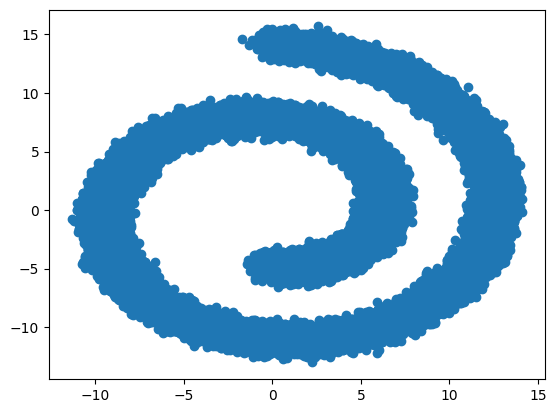

In [2]:
visualize_q1_dataset()

For code simplicity, we will train a continuous-time variant of the diffusion prompt. In practice training objectives and code between discrete-time and continuous-time diffusion models are similar.

Given a data element $x$ and neural net $f_\theta(x, t)$, implement the following diffusion training steps:
1. Sample the diffusion timestep: $t \sim \text{Uniform}(0, 1)$
2. Compute the noise-strength following a cosine schedule: $\alpha_t = \cos\left(\frac{\pi}{2}t\right), \sigma_t = \sin\left(\frac{\pi}{2}t\right)$
3. Apply the forward process - Sample noise $\epsilon \sim N(0,I)$ (same shape as $x$) and compute noised $x_t = \alpha_t x + \sigma_t \epsilon$
4. Estimate $\hat{\epsilon} = f_\theta(x_t, t)$
5. Optimize the loss $L = \lVert \epsilon - \hat{\epsilon} \rVert_2^2$. Here, it suffices to just take the mean over all dimensions.

Note that for the case of continuous-time diffusion, the forward process is $x_{0\to1}$ and reverse process is $x_{1\to0}$

Use an MLP for $f_\theta$ to optimize the loss. You may find the following details helpful.
* Normalize the data using mean and std computed from the train dataset
* Train 100 epochs, batch size 1024, Adam with LR 1e-3 (100 warmup steps, cosine decay to 0)
* MLP with 4 hidden layers and hidden size 64
* Condition on t by concatenating it with input x (i.e. 2D x + 1D t = 3D cat(x, t))

To sample, implement the standard DDPM sampler. You may find the equation from the [DDIM paper](https://arxiv.org/pdf/2010.02502.pdf) helpful, rewritten and re-formatted here for convenience.
$$x_{t-1} = \alpha_{t-1}\left(\frac{x_t - \sigma_t\hat{\epsilon}}{\alpha_t}\right) + \sqrt{\sigma_{t-1}^2 - \eta_t^2}\hat{\epsilon} + \eta_t\epsilon_t$$
where $\epsilon_t \sim N(0, I)$ is random Gaussian noise. For DDPM, let
$$\eta_t = \sigma_{t-1}/\sigma_t\sqrt{1 - \alpha_t^2/\alpha_{t-1}^2}$$
To run the reverse process, start from $x_1 \sim N(0, I)$ and perform `num_steps` DDPM updates (a hyperparameter), pseudocode below.
```
ts = linspace(1 - 1e-4, 1e-4, num_steps + 1)
x = sample_normal
for i in range(num_steps):
    t = ts[i]
    tm1 = ts[i + 1]
    eps_hat = model(x, t)
    x = DDPM_UPDATE(x, eps_hat, t, tm1)
return x
```
Note: If you encounter NaNs, you may need to clip $\sigma_{t-1}^2 - \eta_t^2$ to 0 if it goes negative, as machine precision issues can make it a very small negative number (e.g. -1e-12) if its too close to 0

In [78]:
num_steps = 9
timesteps = torch.tensor(range(0, num_steps), dtype=torch.float32)
schedule = torch.cos((timesteps / num_steps + 0.008) / (1 + 0.008) * torch.pi / 2)**2
baralphas = schedule / schedule[0]
betas = 1 - baralphas / torch.concatenate([baralphas[0:1], baralphas[0:-1]])
alphas = 1 - betas 

class DiffusionBlock(nn.Module):
    def __init__(self, nunits):
        super(DiffusionBlock, self).__init__()
        self.linear = nn.Linear(nunits, nunits)
        
    def forward(self, x: torch.Tensor):
        x = self.linear(x)
        x = nn.functional.relu(x)
        return x
        
class DiffusionModel(nn.Module):
    def __init__(self, nfeatures: int, nblocks: int = 2, nunits: int = 64):
        super(DiffusionModel, self).__init__()
        
        self.inblock = nn.Linear(nfeatures+1, nunits)
        self.midblocks = nn.ModuleList([DiffusionBlock(nunits) for _ in range(nblocks)])
        self.outblock = nn.Linear(nunits, nfeatures)

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        val = torch.hstack([x, t])  # Add t to inputs
        val = self.inblock(val)
        for midblock in self.midblocks:
            val = midblock(val)
        val = self.outblock(val)
        return val

def noise(batch, timesteps):
    eps = torch.randn(size=batch.shape)
    noised = (baralphas[timesteps] ** 0.5).repeat(1, batch.shape[1]) * batch + ((1 - baralphas[timesteps]) ** 0.5).repeat(1, batch.shape[1]) * eps
    return noised, eps

In [105]:
def loss_fn(batch, model):
    timesteps = torch.randint(0, num_steps, size=[len(batch), 1])
    noised, eps = noise(batch, timesteps)
    predicted_noise = model(noised.to(device), timesteps.to(device))
    return OrderedDict(loss = nn.MSELoss()(predicted_noise, eps.to(device)))

def train(model, optim, num_steps, train_loader, epochs, batch_size, device, loss_fn, epoch):
    
    train_losses = OrderedDict()
    model.train()
    pbar = tqdm(total=len(train_loader.dataset))
    for i, batch in enumerate(train_loader):

        out = loss_fn(batch, model)
        optim.zero_grad()
        out['loss'].backward()
        optim.step()
        desc = f'Epoch\t{epoch}'
        for k, v in out.items():
            if k not in train_losses:
                train_losses[k] = []
            train_losses[k].append(v.item())
            avg_loss = np.mean(train_losses[k][-50:])
            desc += f'\t{k} {avg_loss:.4f}'
        pbar.set_description(desc)
        pbar.update(batch.shape[0])
        pbar.close()
    return train_losses

def eval_loss(model, data_loader, loss_fn):

    model.eval()
    total_losses = OrderedDict()

    with torch.no_grad():
        for x in data_loader:
            out = loss_fn(x, model)
            for k, v in out.items():
                total_losses[k] = total_losses.get(k, 0) + v.item() * x.shape[0]

        desc = 'Test \t'
        for k in total_losses.keys():
            total_losses[k] /= len(data_loader.dataset)
            desc += f'\t{k} {total_losses[k]:.4f}'
        print(desc)
    return total_losses

def train_epochs(model, optim, num_steps, train_loader, test_loader, epochs, batch_size, device, loss_fn):
    
    train_losses, test_losses = OrderedDict(), OrderedDict()
    
    for epoch in tqdm_notebook(range(epochs), desc='Epoch', leave=False):
        model.train()
        train_loss = train(model, optim, num_steps, train_loader, epochs, batch_size, device, loss_fn, epoch)
        test_loss = eval_loss(model, test_loader, loss_fn)                          
        for k in train_loss.keys():
            if k not in train_losses:
                train_losses[k] = []
                test_losses[k] = []
            train_losses[k].extend(train_loss[k])
            test_losses[k].append(test_loss[k])
    return train_losses, test_losses

In [106]:
def q1(train_data, test_data):
    """
    train_data: A (100000, 2) numpy array of 2D points
    test_data: A (10000, 2) numpy array of 2D points

    Returns
    - a (# of training iterations,) numpy array of train losses evaluated every minibatch
    - a (# of num_epochs + 1,) numpy array of test losses evaluated at the start of training and the end of every epoch
    - a numpy array of size (9, 2000, 2) of samples drawn from your model.
      Draw 2000 samples for each of 9 different number of diffusion sampling steps
      of evenly logarithmically spaced integers 1 to 512
      hint: np.power(2, np.linspace(0, 9, 9)).astype(int)
    """
    # Initialize variables
    epochs, batch_size = 100, 1024
    lr = 1e-3
    negative_slope = 1e-2
    num_steps, num_samples = 9, 2000
    hidden_layers, hidden_dim = 3, 128
    num_features = train_data.shape[1]

      
    # Create model, optimizer, and loss function
    model = DiffusionModel(nfeatures=num_features, nblocks=4).to(device)
    optim =  torch.optim.Adam(model.parameters(), lr=lr)

    # Load data
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size)
    
    # Run training loop
    train_losses, test_losses = (train_epochs(model, optim, num_steps, 
        train_loader, test_loader, 
        epochs, batch_size, device, loss_fn))

    # Sample model
    all_samples = np.array(np.random.rand(9, 2000, 2))
    
    return train_losses['loss'], test_losses['loss'], all_samples

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch	0	loss 1.0589:   1%|          | 1024/100000 [00:00<00:01, 79945.04it/s]

Test 		loss 0.9632


Epoch	1	loss 0.9774:   1%|          | 1024/100000 [00:00<00:00, 107376.87it/s]


Test 		loss 0.8928


Epoch	2	loss 0.9388:   1%|          | 1024/100000 [00:00<00:00, 121436.53it/s]


Test 		loss 0.8778


Epoch	3	loss 0.8931:   1%|          | 1024/100000 [00:00<00:01, 83303.61it/s]


Test 		loss 0.8367


Epoch	4	loss 0.9123:   1%|          | 1024/100000 [00:00<00:00, 111991.01it/s]


Test 		loss 0.8226


Epoch	5	loss 0.7467:   1%|          | 1024/100000 [00:00<00:00, 145326.09it/s]


Test 		loss 0.7963


Epoch	6	loss 0.7814:   1%|          | 1024/100000 [00:00<00:01, 89963.92it/s]


Test 		loss 0.7716


Epoch	7	loss 0.7374:   1%|          | 1024/100000 [00:00<00:01, 86691.71it/s]


Test 		loss 0.7616


Epoch	8	loss 0.7726:   1%|          | 1024/100000 [00:00<00:01, 98531.02it/s]


Test 		loss 0.7653


Epoch	9	loss 0.7564:   1%|          | 1024/100000 [00:00<00:00, 128399.62it/s]


Test 		loss 0.7638


Epoch	10	loss 0.7690:   1%|          | 1024/100000 [00:00<00:00, 110803.55it/s]


Test 		loss 0.7451


Epoch	11	loss 0.7691:   1%|          | 1024/100000 [00:00<00:00, 141374.83it/s]


Test 		loss 0.7496


Epoch	12	loss 0.7622:   1%|          | 1024/100000 [00:00<00:00, 140763.22it/s]


Test 		loss 0.7482


Epoch	13	loss 0.7454:   1%|          | 1024/100000 [00:00<00:01, 63866.63it/s]


Test 		loss 0.7421


Epoch	14	loss 0.7427:   1%|          | 1024/100000 [00:00<00:00, 128422.66it/s]


Test 		loss 0.7466


Epoch	15	loss 0.7412:   1%|          | 1024/100000 [00:00<00:00, 146351.15it/s]


Test 		loss 0.7581


Epoch	16	loss 0.7548:   1%|          | 1024/100000 [00:00<00:00, 123745.74it/s]


Test 		loss 0.7424


Epoch	17	loss 0.7327:   1%|          | 1024/100000 [00:00<00:00, 102706.19it/s]


Test 		loss 0.7721


Epoch	18	loss 0.7314:   1%|          | 1024/100000 [00:00<00:00, 123298.14it/s]


Test 		loss 0.7580


Epoch	19	loss 0.7527:   1%|          | 1024/100000 [00:00<00:00, 109470.54it/s]


Test 		loss 0.7467


Epoch	20	loss 0.7520:   1%|          | 1024/100000 [00:00<00:01, 92793.94it/s]


Test 		loss 0.7549


Epoch	21	loss 0.7762:   1%|          | 1024/100000 [00:00<00:00, 146977.18it/s]


Test 		loss 0.7531


Epoch	22	loss 0.7028:   1%|          | 1024/100000 [00:00<00:00, 100735.70it/s]


Test 		loss 0.7503


Epoch	23	loss 0.7419:   1%|          | 1024/100000 [00:00<00:00, 153512.31it/s]


Test 		loss 0.7647


Epoch	24	loss 0.7286:   1%|          | 1024/100000 [00:00<00:00, 156813.59it/s]


Test 		loss 0.7609


Epoch	25	loss 0.7796:   1%|          | 1024/100000 [00:00<00:01, 79663.30it/s]


Test 		loss 0.7394


Epoch	26	loss 0.7448:   1%|          | 1024/100000 [00:00<00:00, 151674.52it/s]


Test 		loss 0.7539


Epoch	27	loss 0.7332:   1%|          | 1024/100000 [00:00<00:00, 140652.58it/s]


Test 		loss 0.7558


Epoch	28	loss 0.7981:   1%|          | 1024/100000 [00:00<00:00, 124300.85it/s]


Test 		loss 0.7563


Epoch	29	loss 0.7249:   1%|          | 1024/100000 [00:00<00:00, 115951.71it/s]


Test 		loss 0.7644


Epoch	30	loss 0.7884:   1%|          | 1024/100000 [00:00<00:00, 133687.16it/s]


Test 		loss 0.7281


Epoch	31	loss 0.7773:   1%|          | 1024/100000 [00:00<00:00, 110877.92it/s]


Test 		loss 0.7524


Epoch	32	loss 0.7099:   1%|          | 1024/100000 [00:00<00:00, 127115.17it/s]


Test 		loss 0.7598


Epoch	33	loss 0.7147:   1%|          | 1024/100000 [00:00<00:00, 131925.52it/s]


Test 		loss 0.7504


Epoch	34	loss 0.7267:   1%|          | 1024/100000 [00:00<00:00, 136335.18it/s]


Test 		loss 0.7444


Epoch	35	loss 0.7646:   1%|          | 1024/100000 [00:00<00:00, 117851.15it/s]


Test 		loss 0.7535


Epoch	36	loss 0.7596:   1%|          | 1024/100000 [00:00<00:00, 141547.22it/s]


Test 		loss 0.7504


Epoch	37	loss 0.7926:   1%|          | 1024/100000 [00:00<00:00, 112274.99it/s]


Test 		loss 0.7718


Epoch	38	loss 0.7859:   1%|          | 1024/100000 [00:00<00:00, 122583.76it/s]


Test 		loss 0.7644


Epoch	39	loss 0.7267:   1%|          | 1024/100000 [00:00<00:00, 115390.97it/s]


Test 		loss 0.7584


Epoch	40	loss 0.7407:   1%|          | 1024/100000 [00:00<00:00, 151722.74it/s]


Test 		loss 0.7573


Epoch	41	loss 0.7274:   1%|          | 1024/100000 [00:00<00:00, 123209.71it/s]


Test 		loss 0.7566


Epoch	42	loss 0.7773:   1%|          | 1024/100000 [00:00<00:00, 131553.76it/s]


Test 		loss 0.7551


Epoch	43	loss 0.7335:   1%|          | 1024/100000 [00:00<00:00, 144538.69it/s]


Test 		loss 0.7230


Epoch	44	loss 0.7607:   1%|          | 1024/100000 [00:00<00:00, 108951.25it/s]


Test 		loss 0.7466


Epoch	45	loss 0.7666:   1%|          | 1024/100000 [00:00<00:00, 123792.11it/s]


Test 		loss 0.7468


Epoch	46	loss 0.7241:   1%|          | 1024/100000 [00:00<00:00, 139424.36it/s]


Test 		loss 0.7356


Epoch	47	loss 0.7428:   1%|          | 1024/100000 [00:00<00:00, 156533.54it/s]


Test 		loss 0.7498


Epoch	48	loss 0.7393:   1%|          | 1024/100000 [00:00<00:00, 107565.11it/s]


Test 		loss 0.7650


Epoch	49	loss 0.7480:   1%|          | 1024/100000 [00:00<00:00, 118849.06it/s]


Test 		loss 0.7384


Epoch	50	loss 0.7418:   1%|          | 1024/100000 [00:00<00:00, 103274.20it/s]


Test 		loss 0.7290


Epoch	51	loss 0.7517:   1%|          | 1024/100000 [00:00<00:00, 142349.44it/s]


Test 		loss 0.7424


Epoch	52	loss 0.7558:   1%|          | 1024/100000 [00:00<00:00, 154434.12it/s]


Test 		loss 0.7415


Epoch	53	loss 0.7128:   1%|          | 1024/100000 [00:00<00:00, 134575.19it/s]


Test 		loss 0.7568


Epoch	54	loss 0.7338:   1%|          | 1024/100000 [00:00<00:01, 90287.31it/s]


Test 		loss 0.7489


Epoch	55	loss 0.7546:   1%|          | 1024/100000 [00:00<00:01, 68817.47it/s]


Test 		loss 0.7594


Epoch	56	loss 0.7524:   1%|          | 1024/100000 [00:00<00:00, 129168.06it/s]


Test 		loss 0.7487


Epoch	57	loss 0.7366:   1%|          | 1024/100000 [00:00<00:00, 131646.51it/s]


Test 		loss 0.7490


Epoch	58	loss 0.7736:   1%|          | 1024/100000 [00:00<00:00, 133595.67it/s]


Test 		loss 0.7402


Epoch	59	loss 0.7271:   1%|          | 1024/100000 [00:00<00:00, 102984.47it/s]


Test 		loss 0.7716


Epoch	60	loss 0.7063:   1%|          | 1024/100000 [00:00<00:01, 98081.01it/s]


Test 		loss 0.7524


Epoch	61	loss 0.7395:   1%|          | 1024/100000 [00:00<00:00, 141752.77it/s]


Test 		loss 0.7458


Epoch	62	loss 0.7306:   1%|          | 1024/100000 [00:00<00:00, 103959.13it/s]


Test 		loss 0.7633


Epoch	63	loss 0.7978:   1%|          | 1024/100000 [00:00<00:01, 97162.41it/s]


Test 		loss 0.7319


Epoch	64	loss 0.7494:   1%|          | 1024/100000 [00:00<00:00, 146490.92it/s]


Test 		loss 0.7541


Epoch	65	loss 0.7424:   1%|          | 1024/100000 [00:00<00:01, 72150.37it/s]


Test 		loss 0.7381


Epoch	66	loss 0.7593:   1%|          | 1024/100000 [00:00<00:01, 84415.32it/s]


Test 		loss 0.7496


Epoch	67	loss 0.7599:   1%|          | 1024/100000 [00:00<00:00, 112796.89it/s]


Test 		loss 0.7539


Epoch	68	loss 0.7507:   1%|          | 1024/100000 [00:00<00:00, 144155.44it/s]


Test 		loss 0.7539


Epoch	69	loss 0.8079:   1%|          | 1024/100000 [00:00<00:01, 95605.18it/s]


Test 		loss 0.7356


Epoch	70	loss 0.7258:   1%|          | 1024/100000 [00:00<00:01, 95871.95it/s]


Test 		loss 0.7455


Epoch	71	loss 0.7155:   1%|          | 1024/100000 [00:00<00:00, 168080.75it/s]


Test 		loss 0.7528


Epoch	72	loss 0.7402:   1%|          | 1024/100000 [00:00<00:00, 124517.07it/s]


Test 		loss 0.7389


Epoch	73	loss 0.7082:   1%|          | 1024/100000 [00:00<00:00, 106318.97it/s]


Test 		loss 0.7402


Epoch	74	loss 0.7638:   1%|          | 1024/100000 [00:00<00:00, 171736.87it/s]


Test 		loss 0.7536


Epoch	75	loss 0.7605:   1%|          | 1024/100000 [00:00<00:00, 144107.08it/s]


Test 		loss 0.7364


Epoch	76	loss 0.7427:   1%|          | 1024/100000 [00:00<00:01, 92643.82it/s]


Test 		loss 0.7555


Epoch	77	loss 0.7826:   1%|          | 1024/100000 [00:00<00:00, 157054.42it/s]


Test 		loss 0.7449


Epoch	78	loss 0.7554:   1%|          | 1024/100000 [00:00<00:00, 102083.69it/s]


Test 		loss 0.7478


Epoch	79	loss 0.6915:   1%|          | 1024/100000 [00:00<00:00, 127326.20it/s]


Test 		loss 0.7519


Epoch	80	loss 0.7308:   1%|          | 1024/100000 [00:00<00:00, 153770.62it/s]


Test 		loss 0.7583


Epoch	81	loss 0.8057:   1%|          | 1024/100000 [00:00<00:00, 142614.14it/s]


Test 		loss 0.7515


Epoch	82	loss 0.6864:   1%|          | 1024/100000 [00:00<00:00, 153776.13it/s]


Test 		loss 0.7515


Epoch	83	loss 0.7588:   1%|          | 1024/100000 [00:00<00:01, 94711.28it/s]


Test 		loss 0.7518


Epoch	84	loss 0.7385:   1%|          | 1024/100000 [00:00<00:00, 138932.76it/s]


Test 		loss 0.7579


Epoch	85	loss 0.7388:   1%|          | 1024/100000 [00:00<00:00, 117137.60it/s]


Test 		loss 0.7543


Epoch	86	loss 0.7195:   1%|          | 1024/100000 [00:00<00:00, 109927.24it/s]


Test 		loss 0.7447


Epoch	87	loss 0.7715:   1%|          | 1024/100000 [00:00<00:00, 129624.17it/s]


Test 		loss 0.7597


Epoch	88	loss 0.7621:   1%|          | 1024/100000 [00:00<00:00, 122370.71it/s]


Test 		loss 0.7442


Epoch	89	loss 0.7685:   1%|          | 1024/100000 [00:00<00:00, 109719.44it/s]


Test 		loss 0.7358


Epoch	90	loss 0.7241:   1%|          | 1024/100000 [00:00<00:00, 122622.26it/s]


Test 		loss 0.7504


Epoch	91	loss 0.7443:   1%|          | 1024/100000 [00:00<00:00, 148332.49it/s]


Test 		loss 0.7404


Epoch	92	loss 0.7976:   1%|          | 1024/100000 [00:00<00:00, 127118.93it/s]


Test 		loss 0.7513


Epoch	93	loss 0.6914:   1%|          | 1024/100000 [00:00<00:01, 98063.09it/s]


Test 		loss 0.7544


Epoch	94	loss 0.7445:   1%|          | 1024/100000 [00:00<00:01, 74966.27it/s]


Test 		loss 0.7406


Epoch	95	loss 0.7462:   1%|          | 1024/100000 [00:00<00:00, 118951.10it/s]


Test 		loss 0.7411


Epoch	96	loss 0.7367:   1%|          | 1024/100000 [00:00<00:00, 145208.17it/s]


Test 		loss 0.7625


Epoch	97	loss 0.7372:   1%|          | 1024/100000 [00:00<00:00, 150147.43it/s]


Test 		loss 0.7369


Epoch	98	loss 0.7633:   1%|          | 1024/100000 [00:00<00:00, 120492.84it/s]


Test 		loss 0.7298


Epoch	99	loss 0.7398:   1%|          | 1024/100000 [00:00<00:01, 78348.15it/s]


Test 		loss 0.7505
Final Test Loss: 0.7505


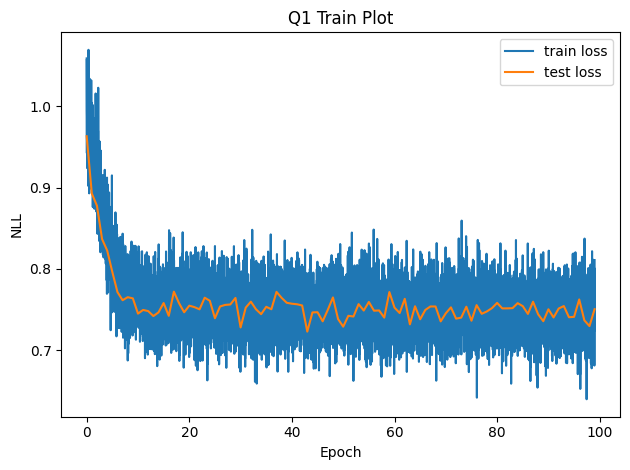

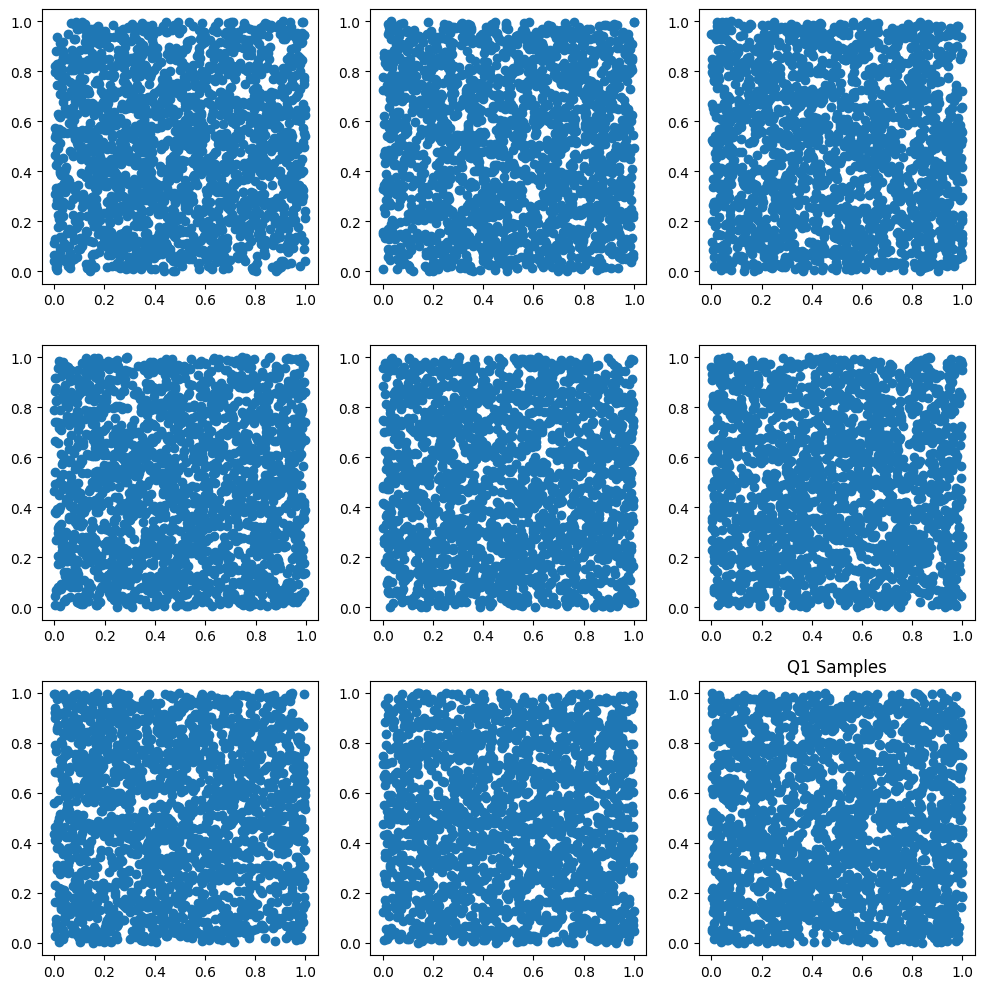

In [107]:
q1_save_results(q1)

# Question 2: Pixel-Space Diffusion on CIFAR-10 [30pt]

In this question, we will train pixel-space UNet diffusion model on CIFAR-10

Execute the cell below to visualize our datasets.

Files already downloaded and verified
Files already downloaded and verified


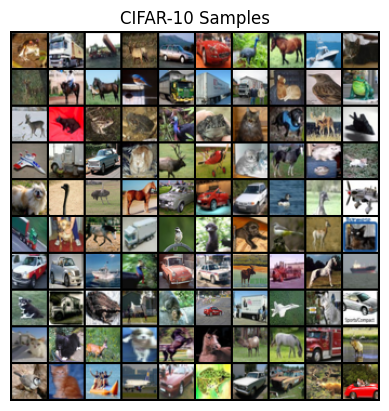

In [17]:
visualize_q2_data()

We'll use a UNet architecture similar to the original [DDPM](https://arxiv.org/abs/2006.11239) paper. We provide the following pseudocode for each part of the model:
```
def timestep_embedding(timesteps, dim, max_period=10000):
    half = dim // 2
    freqs = np.exp(-np.log(max_period) * np.arange(0, half, dtype=float32) / half)
    args = timesteps[:, None].astype(float32) * freqs[None]
    embedding = cat([np.cos(args), np.sin(args)], axis=-1)
    if dim % 2:
        embedding = cat([embedding, np.zeros_like(embedding[:, :1])], axis=-1)
    return embedding

ResidualBlock(in_channels, out_channels, temb_channels)
    Given x, temb
    h = Conv2d(in_channels, out_channels, 3, padding=1)(x)
    h = GroupNorm(num_groups=8, num_channels=out_channels)(h)
    h = SiLU()(h)
    
    temb = Linear(temb_channels, out_channels)(temb)
    h += temb[:, :, None, None] # h is BxDxHxW, temb is BxDx1x1
    
    h = Conv2d(out_channels, out_channels, 3, padding=1)(h)
    h = GroupNorm(num_groups=8, num_channels=out_channels)(h)
    h = SiLU()(h)
    
    if in_channels != out_channels:
        x = Conv2d(in_channels, out_channels, 1)(x)
    return x + h
    
Downsample(in_channels)
    Given x
    return Conv2d(in_channels, in_channels, 3, stride=2, padding=1)(x)

Upsample(in_channels)
    Given x
    x = interpolate(x, scale_factor=2)
    x = Conv2d(in_channels, in_channels, 3, padding=1)(x)
    return x
    
UNet(in_channels, hidden_dims, blocks_per_dim)
    Given x, t
    temb_channels = hidden_dims[0] * 4
    emb = timestep_embedding(t, hidden_dims[0])
    emb = Sequential(Linear(hidden_dims[0], temb_channels), SiLU(), Linear(temb_channels, temb_channels))(emb)
    
    h = Conv2d(in_channels, hidden_dims[0], 3, padding=1)(x)
    hs = [h]
    prev_ch = hidden_dims[0]
    down_block_chans = [prev_ch]
    for i, hidden_dim in enumerate(hidden_dims):
        for _ in range(blocks_per_dim):
            h = ResidualBlock(prev_ch, hidden_dim, temb_channels)(h, emb)
            hs.append(h)
            prev_ch = hidden_dim
            down_block_chans.append(prev_ch)
        if i != len(hidden_dims) - 1:
            h = Downsample(prev_ch)(h)
            hs.append(h)
            down_block_chans.append(prev_ch)
    
    h = ResidualBlock(prev_ch, prev_ch, temb_channels)(h, emb)
    h = ResidualBlock(prev_ch, prev_ch, temb_channels)(h, emb)
    
    for i, hidden_dim in list(enumerate(hidden_dims))[::-1]:
        for j in range(blocks_per_dim + 1):
            dch = down_block_chans.pop()
            h = ResidualBlock(prev_ch + dch, hidden_dim, temb_channels)(cat(h, hs.pop()), emb)
            prev_ch = hidden_dim
            if i and j == blocks_per_dim:
                h = Upsample(prev_ch)(h)
    
    h = GroupNorm(num_groups=8, num_channels=prev_ch)(h)
    h = SiLU()(h)
    out = Conv2d(prev_ch, in_channels, 3, padding=1)(h)
    return out
```

**Hyperparameter details**
* Normalize data to [-1, 1]
* UNET with hidden_dims as [64, 128, 256, 512] and 2 blocks_per_dim
* Train 60 epochs, batch size 256, Adam with LR 1e-3 (100 warmup steps, cosine decay to 0)
* For diffusion schedule, sampling and loss, use the same setup as Q1

You may also find it helpful to clip $\hat{x} = \frac{x_t - \sigma_t \hat{\epsilon}}{\alpha_t}$ to [-1, 1] during each sampling step.

In [ ]:
# """
# U-Net model (including residual blocks, multi-head attention with time-step embeddings t)
# from Denoising Diffusion Probabilistic Models (DDPM) that predicts noise: epsilon_theta(xt, t). 
# """
# class Swish(Module):
#     """
#     ### Swish activation function

#     $$x \cdot \sigma(x)$$
#     """

#     def forward(self, x):
#         return x * torch.sigmoid(x)

# class TimeEmbedding(torch.nn.Module):
#     """
#     ### Embeddings for $t$
#     """

#     def __init__(self, n_channels: int):
#         """
#         * `n_channels` is the number of dimensions in the embedding
#         """
#         super().__init__()
#         self.n_channels = n_channels
#         # First linear layer
#         self.lin1 = torch.nn.Linear(self.n_channels // 4, self.n_channels)
#         # Activation
#         self.act = Swish()
#         # Second linear layer
#         self.lin2 = nn.Linear(self.n_channels, self.n_channels)

#     def forward(self, t: torch.Tensor):
#         # Create sinusoidal position embeddings
#         # [same as those from the transformer](../../transformers/positional_encoding.html)
#         #
#         # \begin{align}
#         # PE^{(1)}_{t,i} &= sin\Bigg(\frac{t}{10000^{\frac{i}{d - 1}}}\Bigg) \\
#         # PE^{(2)}_{t,i} &= cos\Bigg(\frac{t}{10000^{\frac{i}{d - 1}}}\Bigg)
#         # \end{align}
#         #
#         # where $d$ is `half_dim`
#         half_dim = self.n_channels // 8
#         emb = math.log(10_000) / (half_dim - 1)
#         emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
#         emb = t[:, None] * emb[None, :]
#         emb = torch.cat((emb.sin(), emb.cos()), dim=1)

#         # Transform with the MLP
#         emb = self.act(self.lin1(emb))
#         emb = self.lin2(emb)

#         #
#         return emb

# class ResidualBlock(Module):
#     """
#     ### Residual block

#     A residual block has two convolution layers with group normalization.
#     Each resolution is processed with two residual blocks.
#     """

#     def __init__(self, in_channels: int, out_channels: int, time_channels: int,
#                  n_groups: int = 32, dropout: float = 0.1):
#         """
#         * `in_channels` is the number of input channels
#         * `out_channels` is the number of input channels
#         * `time_channels` is the number channels in the time step ($t$) embeddings
#         * `n_groups` is the number of groups for [group normalization](../../normalization/group_norm/index.html)
#         * `dropout` is the dropout rate
#         """
#         super().__init__()
#         # Group normalization and the first convolution layer
#         self.norm1 = nn.GroupNorm(n_groups, in_channels)
#         self.act1 = Swish()
#         self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=(1, 1))

#         # Group normalization and the second convolution layer
#         self.norm2 = nn.GroupNorm(n_groups, out_channels)
#         self.act2 = Swish()
#         self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding=(1, 1))

#         # If the number of input channels is not equal to the number of output channels we have to
#         # project the shortcut connection
#         if in_channels != out_channels:
#             self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=(1, 1))
#         else:
#             self.shortcut = nn.Identity()

#         # Linear layer for time embeddings
#         self.time_emb = nn.Linear(time_channels, out_channels)
#         self.time_act = Swish()

#         self.dropout = nn.Dropout(dropout)

#     def forward(self, x: torch.Tensor, t: torch.Tensor):
#         """
#         * `x` has shape `[batch_size, in_channels, height, width]`
#         * `t` has shape `[batch_size, time_channels]`
#         """
#         # First convolution layer
#         h = self.conv1(self.act1(self.norm1(x)))
#         # Add time embeddings
#         h += self.time_emb(self.time_act(t))[:, :, None, None]
#         # Second convolution layer
#         h = self.conv2(self.dropout(self.act2(self.norm2(h))))

#         # Add the shortcut connection and return
#         return h + self.shortcut(x)

# class AttentionBlock(Module):
#     """
#     ### Attention block

#     This is similar to [transformer multi-head attention](../../transformers/mha.html).
#     """

#     def __init__(self, n_channels: int, n_heads: int = 1, d_k: int = None, n_groups: int = 32):
#         """
#         * `n_channels` is the number of channels in the input
#         * `n_heads` is the number of heads in multi-head attention
#         * `d_k` is the number of dimensions in each head
#         * `n_groups` is the number of groups for [group normalization](../../normalization/group_norm/index.html)
#         """
#         super().__init__()

#         # Default `d_k`
#         if d_k is None:
#             d_k = n_channels
#         # Normalization layer
#         self.norm = nn.GroupNorm(n_groups, n_channels)
#         # Projections for query, key and values
#         self.projection = nn.Linear(n_channels, n_heads * d_k * 3)
#         # Linear layer for final transformation
#         self.output = nn.Linear(n_heads * d_k, n_channels)
#         # Scale for dot-product attention
#         self.scale = d_k ** -0.5
#         #
#         self.n_heads = n_heads
#         self.d_k = d_k

#     def forward(self, x: torch.Tensor, t: Optional[torch.Tensor] = None):
#         """
#         * `x` has shape `[batch_size, in_channels, height, width]`
#         * `t` has shape `[batch_size, time_channels]`
#         """
#         # `t` is not used, but it's kept in the arguments because for the attention layer function signature
#         # to match with `ResidualBlock`.
#         _ = t
#         # Get shape
#         batch_size, n_channels, height, width = x.shape
#         # Change `x` to shape `[batch_size, seq, n_channels]`
#         x = x.view(batch_size, n_channels, -1).permute(0, 2, 1)
#         # Get query, key, and values (concatenated) and shape it to `[batch_size, seq, n_heads, 3 * d_k]`
#         qkv = self.projection(x).view(batch_size, -1, self.n_heads, 3 * self.d_k)
#         # Split query, key, and values. Each of them will have shape `[batch_size, seq, n_heads, d_k]`
#         q, k, v = torch.chunk(qkv, 3, dim=-1)
#         # Calculate scaled dot-product $\frac{Q K^\top}{\sqrt{d_k}}$
#         attn = torch.einsum('bihd,bjhd->bijh', q, k) * self.scale
#         # Softmax along the sequence dimension $\underset{seq}{softmax}\Bigg(\frac{Q K^\top}{\sqrt{d_k}}\Bigg)$
#         attn = attn.softmax(dim=2)
#         # Multiply by values
#         res = torch.einsum('bijh,bjhd->bihd', attn, v)
#         # Reshape to `[batch_size, seq, n_heads * d_k]`
#         res = res.view(batch_size, -1, self.n_heads * self.d_k)
#         # Transform to `[batch_size, seq, n_channels]`
#         res = self.output(res)

#         # Add skip connection
#         res += x

#         # Change to shape `[batch_size, in_channels, height, width]`
#         res = res.permute(0, 2, 1).view(batch_size, n_channels, height, width)

#         #
#         return res

# class DownBlock(Module):
#     """
#     ### Down block

#     This combines `ResidualBlock` and `AttentionBlock`. These are used in the first half of U-Net at each resolution.
#     """

#     def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn: bool):
#         super().__init__()
#         self.res = ResidualBlock(in_channels, out_channels, time_channels)
#         if has_attn:
#             self.attn = AttentionBlock(out_channels)
#         else:
#             self.attn = nn.Identity()

#     def forward(self, x: torch.Tensor, t: torch.Tensor):
#         x = self.res(x, t)
#         x = self.attn(x)
#         return x

# class UpBlock(Module):
#     """
#     ### Up block

#     This combines `ResidualBlock` and `AttentionBlock`. These are used in the second half of U-Net at each resolution.
#     """

#     def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn: bool):
#         super().__init__()
#         # The input has `in_channels + out_channels` because we concatenate the output of the same resolution
#         # from the first half of the U-Net
#         self.res = ResidualBlock(in_channels + out_channels, out_channels, time_channels)
#         if has_attn:
#             self.attn = AttentionBlock(out_channels)
#         else:
#             self.attn = nn.Identity()

#     def forward(self, x: torch.Tensor, t: torch.Tensor):
#         x = self.res(x, t)
#         x = self.attn(x)
#         return x

# class MiddleBlock(Module):
#     """
#     ### Middle block

#     It combines a `ResidualBlock`, `AttentionBlock`, followed by another `ResidualBlock`.
#     This block is applied at the lowest resolution of the U-Net.
#     """

#     def __init__(self, n_channels: int, time_channels: int):
#         super().__init__()
#         self.res1 = ResidualBlock(n_channels, n_channels, time_channels)
#         self.attn = AttentionBlock(n_channels)
#         self.res2 = ResidualBlock(n_channels, n_channels, time_channels)

#     def forward(self, x: torch.Tensor, t: torch.Tensor):
#         x = self.res1(x, t)
#         x = self.attn(x)
#         x = self.res2(x, t)
#         return x

# class Upsample(nn.Module):
#     """
#     ### Scale up the feature map by $2 \times$
#     """

#     def __init__(self, n_channels):
#         super().__init__()
#         self.conv = nn.ConvTranspose2d(n_channels, n_channels, (4, 4), (2, 2), (1, 1))

#     def forward(self, x: torch.Tensor, t: torch.Tensor):
#         # `t` is not used, but it's kept in the arguments because for the attention layer function signature
#         # to match with `ResidualBlock`.
#         _ = t
#         return self.conv(x)

# class Downsample(nn.Module):
#     """
#     ### Scale down the feature map by $\frac{1}{2} \times$
#     """

#     def __init__(self, n_channels):
#         super().__init__()
#         self.conv = nn.Conv2d(n_channels, n_channels, (3, 3), (2, 2), (1, 1))

#     def forward(self, x: torch.Tensor, t: torch.Tensor):
#         # `t` is not used, but it's kept in the arguments because for the attention layer function signature
#         # to match with `ResidualBlock`.
#         _ = t
#         return self.conv(x)

# class UNet(Module):
    
#     def __init__(self, image_channels: int = 3, n_channels: int = 64,
#                  ch_mults: Union[Tuple[int, ...], List[int]] = (1, 2, 2, 4),
#                  is_attn: Union[Tuple[bool, ...], List[bool]] = (False, False, True, True),
#                  n_blocks: int = 2):
#         """
#         * `image_channels` is the number of channels in the image. $3$ for RGB.
#         * `n_channels` is number of channels in the initial feature map that we transform the image into
#         * `ch_mults` is the list of channel numbers at each resolution. The number of channels is `ch_mults[i] * n_channels`
#         * `is_attn` is a list of booleans that indicate whether to use attention at each resolution
#         * `n_blocks` is the number of `UpDownBlocks` at each resolution
#         """
#         super().__init__()

#         # Number of resolutions
#         n_resolutions = len(ch_mults)

#         # Project image into feature map
#         self.image_proj = nn.Conv2d(image_channels, n_channels, kernel_size=(3, 3), padding=(1, 1))

#         # Time embedding layer. Time embedding has `n_channels * 4` channels
#         self.time_emb = TimeEmbedding(n_channels * 4)

#         # #### First half of U-Net - decreasing resolution
#         down = []
#         # Number of channels
#         out_channels = in_channels = n_channels
#         # For each resolution
#         for i in range(n_resolutions):
#             # Number of output channels at this resolution
#             out_channels = in_channels * ch_mults[i]
#             # Add `n_blocks`
#             for _ in range(n_blocks):
#                 down.append(DownBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
#                 in_channels = out_channels
#             # Down sample at all resolutions except the last
#             if i < n_resolutions - 1:
#                 down.append(Downsample(in_channels))

#         # Combine the set of modules
#         self.down = nn.ModuleList(down)

#         # Middle block
#         self.middle = MiddleBlock(out_channels, n_channels * 4, )

#         # Second half of U-Net - increasing resolution
#         up = []
#         # Number of channels
#         in_channels = out_channels
#         # For each resolution
#         for i in reversed(range(n_resolutions)):
#             # `n_blocks` at the same resolution
#             out_channels = in_channels
#             for _ in range(n_blocks):
#                 up.append(UpBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
#             # Final block to reduce the number of channels
#             out_channels = in_channels // ch_mults[i]
#             up.append(UpBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
#             in_channels = out_channels
#             # Up sample at all resolutions except last
#             if i > 0:
#                 up.append(Upsample(in_channels))

#         # Combine the set of modules
#         self.up = nn.ModuleList(up)

#         # Final normalization and convolution layer
#         self.norm = nn.GroupNorm(8, n_channels)
#         self.act = Swish()
#         self.final = nn.Conv2d(in_channels, image_channels, kernel_size=(3, 3), padding=(1, 1))

#     def forward(self, x: torch.Tensor, t: torch.Tensor):
#         """
#         * `x` has shape `[batch_size, in_channels, height, width]`
#         * `t` has shape `[batch_size]`
#         """

#         # Get time-step embeddings
#         t = self.time_emb(t)

#         # Get image projection
#         x = self.image_proj(x)

#         # `h` will store outputs at each resolution for skip connection
#         h = [x]
#         # First half of U-Net
#         for m in self.down:
#             x = m(x, t)
#             h.append(x)

#         # Middle (bottom)
#         x = self.middle(x, t)

#         # Second half of U-Net
#         for m in self.up:
#             if isinstance(m, Upsample):
#                 x = m(x, t)
#             else:
#                 # Get the skip connection from first half of U-Net and concatenate
#                 s = h.pop()
#                 x = torch.cat((x, s), dim=1)
#                 #
#                 x = m(x, t)

#         # Final normalization and convolution
#         return self.final(self.act(self.norm(x)))
    
# import math
# from typing import Optional, Tuple, Union, List
# from labml_helpers.module import Module
# import torch   
# from torch import sigmoid   
# from torch import nn

In [ ]:
def q2(train_data, test_data):
    """
    train_data: A (50000, 32, 32, 3) numpy array of images in [0, 1]
    test_data: A (10000, 32, 32, 3) numpy array of images in [0, 1]

    Returns
    - a (# of training iterations,) numpy array of train losses evaluated every minibatch
    - a (# of num_epochs + 1,) numpy array of test losses evaluated at the start of training and the end of every epoch
    - a numpy array of size (10, 10, 32, 32, 3) of samples in [0, 1] drawn from your model.
      The array represents a 10 x 10 grid of generated samples. Each row represents 10 samples generated
      for a specific number of diffusion timesteps. Do this for 10 evenly logarithmically spaced integers
      1 to 512, i.e. np.power(2, np.linspace(0, 9, 10)).astype(int)
    """

    """ YOUR CODE HERE """

    return train_losses, test_losses, samples

In [ ]:
q2_save_results(q2)

# Question 3: Class-Conditional Latent-Space Diffusion on CIFAR-10 with DiT [60pt]

In this question, we will train latent-space [Diffusion Transformer (DiT)](https://arxiv.org/abs/2212.09748) model on CIFAR-10 **with class conditioning.**

Execute the cell below to visualize our datasets.

In [ ]:
visualize_q3_data()

## Part 3(a) VAE reconstructions and Scale Factor [10pt]

Similar to how we learned a AR model in VQGAN latent space for homework 1, in this question, you will train a diffusion model in the latent space of a VAE. Note that since diffusion models can model continuous distributions, we do not need a discretization bottleneck in the VAE, and the latent space itself is continuous.

Below, we specify each of the relevant properties or functions that you may need.

In [ ]:
# @property
# def latent_shape(self) -> Tuple[int, int, int]:
#     """Size of the encoded representation"""
#
# def encode(self, x: np.ndarray) -> np.ndarray:
#     """Encode an image x. Note: Channel dim is in dim 1
#
#     Args:
#         x (np.ndarray, dtype=float32): Image to encode. shape=(batch_size, 3, 32, 32). Values in [-1, 1]
#
#     Returns:
#         np.ndarray: Encoded image. shape=(batch_size, 4, 8, 8). Unbounded values
#     """
#
# def decode(self, z: np.ndarray) -> np.ndarray:
#     """Decode an encoded image.
#
#     Args:
#         z (np.ndarray, dtype=float32): Encoded image. shape=(batch_size, 4, 8, 8). Unbounded values.
#
#     Returns:
#         np.ndarray: Decoded image. shape=(batch_size, 3, 32, 32). Values in [-1, 1]
#     """
#

In this part, feed the given images through the VAE to compute and visualize reconstructions. In addition, you will compute a scale factor that will be needed during diffusion training to help normalize the data.

To estimate the scale factor, encode 1000 images into the VAE latent space, flatten the entire tensor along all dimensions, and compute the standard deviation.

In [ ]:
def q3_a(images, vae):
    """
    images: (1000, 32, 32, 3) numpy array in [0, 1], the images to pass through the encoder and decoder of the vae
    vae: a vae model, trained on the relevant dataset

    Returns
    - a numpy array of size (50, 2, 32, 32, 3) of the decoded image in [0, 1] consisting of pairs
      of real and reconstructed images
    - a float that is the scale factor
    """

    """ YOUR CODE HERE """

    return autoencoded_images, scale_factor

In [ ]:
q3a_save_results(q3_a)

## Part 3(b) Diffusion Transformer [30pt]
In this part, you will train a Diffusion Transformer (Dit) on the latent space of the above pretrained VAE. You can use your Transformer implementation from HW1 as the core part of the DiT implementation.

Below, we outline the key modifications needed on top of the standard Transformer for DiT.
```
def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float64)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb

def get_2d_sincos_pos_embed(embed_dim, grid_size):
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    return pos_embed

def modulate(x, shift, scale):
    return x * (1 + scale.unsqueeze(1)) + shift.unsqueeze(1)

DiTBlock(hidden_size, num_heads)
    Given x (B x L x D), c (B x D)
    c = SiLU()(c)
    c = Linear(hidden_size, 6 * hidden_size)(c)
    shift_msa, scale_msa, gate_msa, shift_mlp, scale_mlp, gate_mlp = c.chunk(6, dim=1)
    
    h = LayerNorm(hidden_size, elementwise_affine=False)(x)
    h = modulate(h, shift_msa, scale_msa)
    x = x + gate_msa.unsqueeze(1) * Attention(hidden_size, num_heads)(h)
    
    h = LayerNorm(hidden_size, elementwise_affine=False)(x)
    h = modulate(h, shift_mlp, scale_mlp)
    x = x + gate_mlp.unsqueeze(1) * MLP(hidden_size)(h)
    
    return x
    
FinalLayer(hidden_size, patch_size, out_channels)
    Given x (B x L x D), c (B x D)
    c = SiLU()(c)
    c = Linear(hidden_size, 2 * hidden_size)(c)
    shift, scale = c.chunk(2, dim=1)
    x = LayerNorm(hidden_size, elementwise_affine=False)(x)
    x = modulate(x, shift, scale)
    x = Linear(hidden_size, patch_size * patch_size * out_channels)(x)
    return x
    
DiT(input_shape, patch_size, hidden_size, num_heads, num_layers, num_classes, cfg_dropout_prob)
    Given x (B x C x H x W) - image, y (B) - class label, t (B) - diffusion timestep
    x = patchify_flatten(x) # B x C x H x W -> B x (H // P * W // P) x D, P is patch_size
    x += pos_embed # see get_2d_sincos_pos_embed
    
    t = compute_timestep_embedding(t) # Same as in UNet
    if training:
        y = dropout_classes(y, cfg_dropout_prob) # Randomly dropout to train unconditional image generation
    y = Embedding(num_classes + 1, hidden_size)(y)
    c = t + y
    
    for _ in range(num_layers):
        x = DiTBlock(hidden_size, num_heads)(x, c)
    
    x = FinalLayer(hidden_size, patch_size, out_channels)(x)
    x = unpatchify(x) # B x (H // P * W // P) x (P * P * C) -> B x C x H x W
    return x
```

**Hyperparameter details**
* Normalize image to [-1, 1], (2) Encode using the VAE, (3) divide latents by the scale_factor compute in part (a)
* Transformer with patch_size 2, hidden_size 512, num_heads 8, num_layers 12
* Train 60 epochs, batch size 256, Adam with LR 1e-3 (100 warmup steps, cosine decay to 0)
* When sampling, remember to multiple the final generated latents by the scale_factor before feeding it through the decoder
* For diffusion schedule, sampling and loss, use the same setup as Q1

For class conditioning, learn an embedding for each class, and an extra embedding to represent the null class. To condition, add the class embedding to the timestep embedding before feeding it into the transformer blocks (see pseudocode). **Train your class conditional diffusion models while dropping out the class (replace with null class) 10% of the time. This will be necessary for part (c).**

**Remember to save your model parameters after training, as you will need them for part (c)**

In [ ]:
def q3_b(train_data, train_labels, test_data, test_labels, vae):
    """
    train_data: A (50000, 32, 32, 3) numpy array of images in [0, 1]
    train_labels: A (50000,) numpy array of class labels
    test_data: A (10000, 32, 32, 3) numpy array of images in [0, 1]
    test_labels: A (10000,) numpy array of class labels
    vae: a pretrained VAE

    Returns
    - a (# of training iterations,) numpy array of train losses evaluated every minibatch
    - a (# of num_epochs + 1,) numpy array of test losses evaluated at the start of training and the end of every epoch
    - a numpy array of size (10, 10, 32, 32, 3) of samples in [0, 1] drawn from your model.
      The array represents a 10 x 10 grid of generated samples. Each row represents 10 samples generated
      for a specific class (i.e. row 0 is class 0, row 1 class 1, ...). Use 512 diffusion timesteps
    """

    """ YOUR CODE HERE """

    return train_losses, test_losses, samples

In [ ]:
q3b_save_results(q3_b)

## Part 3(c) Classifier-Free Guidance [20pt]
In this part, you will implement [Classifier-Free Guidance](https://arxiv.org/abs/2207.12598) (CFG). CFG is a widely used method during diffusion model sampling to push samples towards more accurately aligning with the conditioning information (e.g. class, text caption).

Implement CFG requires a small modification to the diffusion sampling code. Given a CIFAR-10 class label, instead of using $\hat{\epsilon} = f_\theta(x_t, t, y)$ to sample, use:
$$\hat{\epsilon} = f_\theta(x_t, t, \varnothing) + w(f_\theta(x_t, t, y) - f_\theta(x_t, t, \varnothing))$$
where $w$ is a sampling hyperparameter that controls the strength of CFG. $\varnothing$ indicates the unconditional model with the class label dropped out, which your pre-trained UNet from 3(b) should support. Note that $w = 1$ recovers standard sampling.

Note: It may be expected to see worse samples (e.g. sautrated images) when CFG value is too high. Generation quality is closer to a U-shape when increasing CFG values (gets better, then worse)

In [ ]:
def q3_c(vae):
    """
    vae: a pretrained vae

    Returns
    - a numpy array of size (4, 10, 10, 32, 32, 3) of samples in [0, 1] drawn from your model.
      The array represents a 4 x 10 x 10 grid of generated samples - 4 10 x 10 grid of samples
      with 4 different CFG values of w = {1.0, 3.0, 5.0, 7.5}. Each row of the 10 x 10 grid
      should contain samples of a different class. Use 512 diffusion sampling timesteps.
    """

    """ YOUR CODE HERE """

    return samples

In [ ]:
q3c_save_results(q3_c)

#  References
https://nn.labml.ai/diffusion/index.html